[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# The Extended Kalman Filter

In [1]:
#format the book
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function
import book_format
book_format.load_style()

At this point in the book we have developed the theory for the linear Kalman filter. Then, in the last two chapters we broached the topic of using Kalman filters for nonlinear problems. I chose to start off with the Unscented Kalman filter, which probably felt like quite a departure from the linear Kalman filter math. It was also a departure from the historical development of the Kalman filter.

Shortly after Dr. Kálmán published his paper on the Kalman filter people recognized that his theory was limited to linear problems and immediately began work on extending the theory to work with nonlinear problems. As I have said elsewhere the only equation we really know how to solve is $\mathbf{Ax} = \mathbf{b}$. That is a slight exaggeration. Many of us have spent years at school learning sophisticated tricks and techniques to handle equations that are not linear. Yet after all that work the vast majority of equations that arise from simple physical systems remain intractable. Certainly there is no way to find general analytic solutions to the Kalman filter equations for nonlinear systems. 

In this chapter we will learn the Extended Kalman filter (EKF). The EKF handles nonlinearity by linearizing the system at the point of the current estimate, and then the usual Kalman filter is used to filter this linearized system. It was one of the very first techniques used for nonlinear problems, and it remains the most common technique. Most filters in real world use are EKFs. 

The EKF provides significant mathematical challenges to the designer of the filter; this is the most challenging chapter of the book. To be honest, I do everything I can to avoid the EKF in favor of other techniques that have been developed to filter nonlinear problems. However, the topic is unavoidable; all classic papers and a majority of current papers in the field use the EKF. Even if you do not use the EKF in your own work you will need to be familiar with the topic to be able to read the literature. 

## Linearizing the System Model

The extended Kalman filter (EKF) works by linearizing the system model for each update. For example, consider the problem of tracking a cannonball in flight. Obviously it follows a curved flight path. However, if our update rate is small enough, say 1/10 second, then the trajectory over that time is nearly linear. If we linearize that short segment we will get an answer very close to the actual value, and we can use that value to perform the prediction step of the filter. There are many ways to linearize a set of nonlinear differential equations, and the topic is somewhat beyond the scope of this book. In practice, a Taylor series approximation is frequently used with EKFs, and that is what we will use. 

Consider the function $f(x)=x^2−2x$. We want a linear approximation of this function so that we can use it in the Kalman filter. We will see how it is used in the Kalman filter in the next section, so don't worry about that yet. We can see that there is no single linear function (line) that gives a close approximation of this function. However, during each innovation (update) of the Kalman filter we know its current state, so if we linearize the function at that value we will have a close approximation. For example, suppose our current state is $x=1.5$. What would be a good linearization for this function?

We can use any linear function that passes through the curve at (1.5,-0.75). For example, consider using f(x)=8x−12.75 as the linearization, as in the plot below.

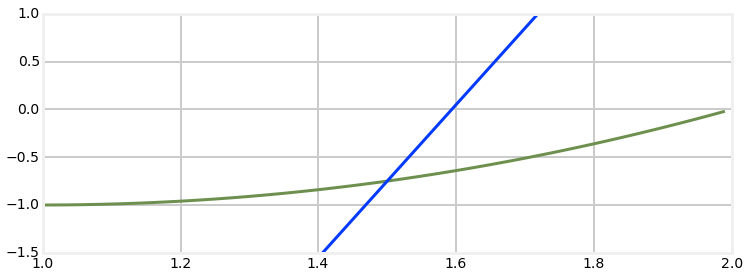

In [2]:
import numpy as np
import matplotlib.pyplot as plt

xs =  np.arange(0, 2, 0.01)
ys = [x**2 - 2*x for x in xs]

def y(x): 
    return 8*x - 12.75

plt.plot (xs, ys)
plt.plot ([1.25, 1.75], [y(1.25), y(1.75)])
plt.xlim(1, 2)
plt.ylim([-1.5, 1])
plt.show()

This is not a good linearization for $f(x)$. It is exact for $x=1.5$, but quickly diverges when $x$ varies by a small amount.

A much better approach is to use the slope of the function at the evaluation point as the linearization. We find the slope by taking the first derivative of the function:

$$f(x) = x^2 -2x \\
\frac{df}{dx} = 2x - 2$$, 
 
so the slope at 1.5 is $2*1.5-2=1$. Let's plot that.

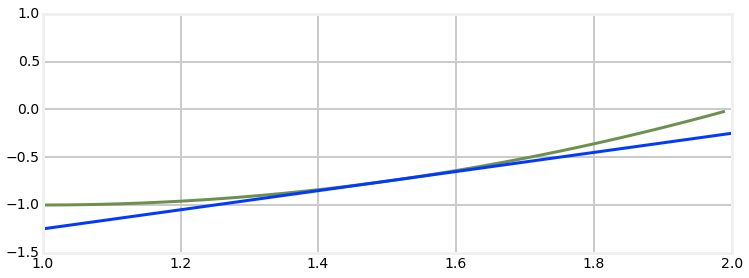

In [3]:
def y(x): 
    return x - 2.25

plt.plot(xs, ys)
plt.plot([1, 2], [y(1), y(2)])
plt.xlim(1, 2)
plt.ylim([-1.5, 1])
plt.show()

Here we can see that this linearization is much better. It is still exactly correct at $x=1.5$, but the errors are very small as x varies. Compare the tiny error at $x=1.4$ vs the very large error at $x=1.4$ in the previous plot. This does not constitute a formal proof of correctness, but this sort of geometric depiction should be fairly convincing. Certainly it is easy to see that in this case if the line had any other slope the errors would accumulate more quickly. 

## Linearizing the Kalman Filter

To implement the extended Kalman filter we will leave the linear equations as they are, and use partial derivatives to evaluate the system matrix $\mathbf{F}$ and the measurement matrix $\mathbf{H}$ at the state at time t ($\mathbf{x}_t$). In other words we linearize the equations at time t by finding the slope (derivative) of the equations at that time. Since $\mathbf{F}$ also depends on the control input vector $\mathbf{u}$ we will need to include that term:

$$
\begin{aligned}
F 
&\equiv {\frac{\partial{f}}{\partial{x}}}\biggr|_{{x_t},{u_t}} \\
H &\equiv \frac{\partial{h}}{\partial{x}}\biggr|_{x_t} 
\end{aligned}
$$

All this means is that at each update step we compute $\mathbf{F}$ as the partial derivative of our function $f()$ evaluated at x. We then use a computational technique, such as Taylor expansion, to turn this into a set of linear equations.

For nonlinear problems our function $f()$ is a set of differential equations. Modeling physical systems with differential equations is well outside the scope of this book. You will need to be reasonably well versed in this branch of applied mathematics to successfully implement the EKF for your problem. If you have not read it yet, please read the section **Modeling Dynamic Systems** in the **Kalman Filter Math** chapter as it contains the math that you will need to complete this chapter.

I think the easiest way to understand the EKF is to just start off with an example. Perhaps the reason for some of my mathematical choices will not be clear, but trust that the end result will be an EKF.

## Example: Tracking a Flying Airplane

We will start by simulating tracking an airplane by using ground based radar. Radars work by emitting a beam of radio waves and scanning for a return bounce. Anything in the beam's path will reflects some of the signal back to the radar. By timing how long it takes for the reflected signal to get back to the radar the system can compute the *slant distance* - the straight line distance from the radar installation to the object.

For this example we want to take the slant range measurement from the radar and compute the horizontal position (distance of aircraft from the radar measured over the ground) and altitude of the aircraft, as in the diagram below.

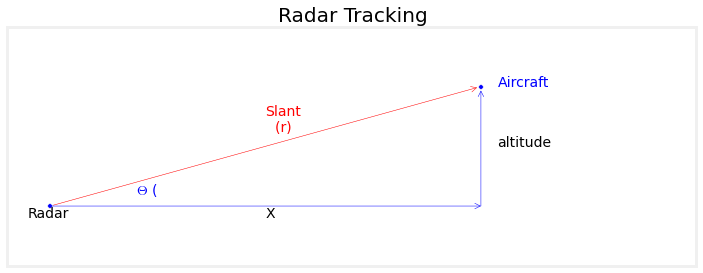

In [4]:
import ekf_internal
ekf_internal.show_radar_chart()

As discussed in the introduction, our measurement model is the nonlinear function $x=\sqrt{slant^2 - altitude^2}$. Therefore we will need a nonlinear 

Predict step:

$$
\begin{array}{ll}
\textbf{Linear} & \textbf{Nonlinear} \\
x = Fx & x = \underline{f(x)} \\
P = FPF^T + Q & P = FPF^T + Q
\end{array}
$$

Update step:

$$
\begin{array}{ll}
\textbf{Linear} & \textbf{Nonlinear} \\
K = PH^T(HPH^T + R)^{-1}& K = PH^T(HPH^T + R)^{-1}\\
x = x + K(z-Hx) & x = x + K(z-\underline{h(x)}) \\
P = P(I - KH) & P = P(I - KH)\\
\end{array}
$$

As we can see there are two minor changes to the Kalman filter equations, which I have underlined. The first change replaces the equation $\mathbf{x} = \mathbf{Fx}$ with $\mathbf{x} = f(\mathbf{x})$. In the Kalman filter, $\mathbf{Fx}$ is how we compute the new state based on the old state. However, in a nonlinear system we cannot use linear algebra to compute this transition. So instead we hypothesize a nonlinear function $f()$ which performs this function. Likewise, in the Kalman filter we convert the state to a measurement with the linear function $\mathbf{Hx}$. For the extended Kalman filter we replace this with a nonlinear function $h()$, giving $\mathbf{z}_x = h(\mathbf{x})$.

The only question left is how do we implement and use $f()$ and $h()$ in the Kalman filter if they are nonlinear? We reach for the single tool that we have available for solving nonlinear equations - we linearize them at the point we want to evaluate the system.  For example, consider the function $f(x) = x^2 -2x$.

The rest of the equations are unchanged, so $f()$ and $h()$ must produce a matrix that approximates the values of the matrices $\mathbf{F}$ and $\mathbf{H}$ at the current value for $\mathbf{x}$. We do this by computing the partial derivatives of the state and measurements functions:

### Design the State Variables

So we want to track the position of an aircraft assuming a constant velocity and altitude, and measurements of the slant distance to the aircraft. That means we need 3 state variables - horizontal distance, velocity, and altitude.

$$\mathbf{x} = \begin{bmatrix}distance \\velocity\\ altitude\end{bmatrix}=  \begin{bmatrix}x_{pos} \\x_{vel}\\ x_{alt}\end{bmatrix}$$

### Design the System Model

We will model this as a set of differential equations. So we need an equation in the form 
$$\dot{\mathbf{x}} = \mathbf{Ax} + \mathbf{w}$$

where $\mathbf{w}$ is the system noise. 

Let's work out the equation for each of the rows in $\mathbf{x}.$

The first row is $\dot{x}_{pos}$, which is the velocity of the airplane. So we can say 

$$\dot{x}_{pos} = x_{vel}$$

The second row is $\dot{x}_{vel}$, which is the acceleration of the airplane. We assume constant velocity, so the acceleration equals zero. However, we also assume system noise due to things like buffeting winds, errors in control inputs, and so on, so we need to add an error $w_{acc}$ to the term, like so

$$\dot{x}_{vel} = 0 + w_{acc}$$

The final row contains $\dot{x}_{alt}$, which is the rate of change in the altitude. We assume a constant altitude, so this term is 0, but as with acceleration we need to add in a noise term to account for things like wind, air density, and so on. This gives us

$$\dot{x}_{alt} = 0 + w_{alt}$$

We turn this into matrix form with the following:

$$\dot{\mathbf{x}} = \begin{bmatrix} 0 & 1 & 0 \\ 0& 0& 0 \\ 0&0&0\end{bmatrix}
\begin{bmatrix}x_{pos} \\x_{vel}\\ x_{alt}\end{bmatrix} + \begin{bmatrix}0 \\w_{vel}\\ w_{alt}\end{bmatrix}
$$

Now we have our differential equations for the system we can somehow solve for them to get our familiar Kalman filter state equation

$$ \mathbf{x}=\mathbf{Fx}$$

Solving an arbitrary set of differential equations is beyond the scope of this book, however most Kalman filters are amenable to Taylor-series expansion which I will briefly explain here without proof. The section **Modeling Dynamic Systems** in the **Kalman Filter Math** chapter contains much more information on this technique.

Given the partial differential equation 

$$\mathbf{F} = \frac{\partial f(\mathbf{x})}{\partial x}$$

the solution is $e^{\mathbf{F}t}$. This is a standard answer learned in a first year partial differential equations course, and is not intuitively obvious from the material presented so far. However, we can compute the exponential matrix $e^{\mathbf{F}t}$ using a Taylor-series expansion in the form:

$$\Phi = \mathbf{I} + \mathbf{F}\Delta t + \frac{(\mathbf{F}\Delta t)^2}{2!} +  \frac{(\mathbf{F}\Delta t)^3}{3!} + \ldots$$

You may expand that equation to as many terms as required for accuracy, however many problems only use the first term

$$\Phi \approx \mathbf{I} + \mathbf{F}\Delta t$$

We can then compute the system matrix by substituting $\Phi$ in $x(t_k) = \Phi(\Delta t)x(t_{k-1})$. Thus, $\Phi$ is our system matrix.

We cannot use Greek symbols in Python, so the code uses the symbol `F` for $\Phi$. This is admittedly confusing. In the math above $\mathbf{F}$ represents the system of partial differential equations, and $\Phi$ is the system matrix. In the Python the partial differential equations are not represented in the code, and the system matrix is `F`.

### Design the Measurement Model

The measurement function for our filter needs to take the filter state $\mathbf{x}$ and turn it into a slant range distance. This is nothing more than the Pythagorean theorem.

$$h(\mathbf{x}) = \sqrt{x_{pos}^2 + x_{alt}^2}$$

The relationship between the slant distance and the position on the ground is nonlinear due to the square root term.
So what we need to do is linearize the measurement function at some point. As we discussed above, the best way to linearize an equation at a point is to find its slope, which we do by taking its derivative.

$$
\mathbf{H} \equiv \frac{\partial{h}}{\partial{x}}\biggr|_x 
$$

The derivative of a matrix is called a Jacobian, which in general takes the form 

$$\frac{\partial \mathbf{h}}{\partial \mathbf{x}} = 
\begin{bmatrix}
\frac{\partial h_1}{\partial x_1} & \frac{\partial h_1}{\partial x_2} &\dots \\
\frac{\partial h_2}{\partial x_1} & \frac{\partial h_2}{\partial x_2} &\dots \\
\vdots & \vdots
\end{bmatrix}
$$

In other words, each element in the matrix is the partial derivative of the function $h$ with respect to the variables $x$. For our problem we have

$$\mathbf{H} = \begin{bmatrix}\frac{\partial h}{\partial x_{pos}} & \frac{\partial h}{\partial x_{vel}} & \frac{\partial h}{\partial x_{alt}}\end{bmatrix}$$

where $h(x) = \sqrt{x_{pos}^2 + x_{alt}^2}$ as given above.

Solving each in turn:

$$\begin{aligned}
\frac{\partial h}{\partial x_{pos}} &= \\ &=\frac{\partial}{\partial x_{pos}} \sqrt{x_{pos}^2 + x_{alt}^2} \\ &= \frac{x_{pos}}{\sqrt{x^2 + x_{alt}^2}}
\end{aligned}$$

and

$$\begin{aligned}
\frac{\partial h}{\partial x_{vel}} &=\\
&= \frac{\partial}{\partial x_{vel}} \sqrt{x_{pos}^2 + x_{alt}^2} \\ 
&= 0
\end{aligned}$$

and

$$\begin{aligned}
\frac{\partial h}{\partial x_{alt}} &=\\ &= \frac{\partial}{\partial x_{alt}} \sqrt{x_{pos}^2 + x_{alt}^2} \\ &= \frac{x_{alt}}{\sqrt{x_{pos}^2 + x_{alt}^2}}
\end{aligned}$$

giving us 

$$\mathbf{H} = 
\begin{bmatrix}
\frac{x_{pos}}{\sqrt{x_{pos}^2 + x_{alt}^2}} & 
0 &
&
\frac{x_{alt}}{\sqrt{x_{pos}^2 + x_{alt}^2}}
\end{bmatrix}$$

This may seem daunting, so step back and recognize that all of this math is just doing something very simple. We have an equation for the slant range to the airplane which is nonlinear. The Kalman filter only works with linear equations, so we need to find a linear equation that approximates $\mathbf{H}$ As we discussed above, finding the slope of a nonlinear equation at a given point is a good approximation. For the Kalman filter, the 'given point' is the state variable $\mathbf{x}$ so we need to take the derivative of the slant range with respect to $\mathbf{x}$. 

To make this more concrete, let's now write a Python function that computes the Jacobian of $\mathbf{H}$. The `ExtendedKalmanFilter` class will be using this to generate `ExtendedKalmanFilter.H` at each step of the process.

In [5]:
from math import sqrt
def HJacobian_at(x):
    """ compute Jacobian of H matrix for state x """

    horiz_dist = x[0]
    altitude   = x[2]
    denom = sqrt(horiz_dist**2 + altitude**2)
    return array ([[horiz_dist/denom, 0., altitude/denom]])

Finally, let's provide the code for $h(\mathbf{x})$

In [6]:
def hx(x):
    """ compute measurement for slant range that would correspond 
    to state x.
    """
    
    return (x[0]**2 + x[2]**2) ** 0.5

Now lets write a simulation for our radar.

In [7]:
from numpy.random import randn
import math

class RadarSim(object):
    """ Simulates the radar signal returns from an object flying 
    at a constant altityude and velocity in 1D. 
    """
    
    def __init__(self, dt, pos, vel, alt):
        self.pos = pos
        self.vel = vel
        self.alt = alt
        self.dt = dt
        
    def get_range(self):
        """ Returns slant range to the object. Call once for each
        new measurement at dt time from last call.
        """
        
        # add some process noise to the system
        self.vel = self.vel  + .1*randn()
        self.alt = self.alt + .1*randn()
        self.pos = self.pos + self.vel*self.dt
    
        # add measurement noise
        err = self.pos * 0.05*randn()
        slant_dist = math.sqrt(self.pos**2 + self.alt**2)
        
        return slant_dist + err

Now we can implement our filter. I have not yet designed $\mathbf{R}$ and $\mathbf{Q}$ which is required to get optimal performance. However, we have already covered a lot of confusing material and I want you to see concrete examples as soon as possible. Therefore I will use 'reasonable' values for $\mathbf{R}$ and $\mathbf{Q}$.

The `FilterPy` library provides the class `ExtendedKalmanFilter`. It works very similar to the `KalmanFilter` class we have been using, except that it allows you to provide functions that compute the Jacobian of $\mathbf{H}$ and the function $h(\mathbf{x})$. We have already written the code for these two functions, so let's just get going.

We start by importing the filter and creating it. There are 3 variables in `x` and only 1 measurement. At the same time we will create our radar simulator.

    from filterpy.kalman import ExtendedKalmanFilter

    rk = ExtendedKalmanFilter(dim_x=3, dim_z=1)
    radar = RadarSim(dt, pos=0., vel=100., alt=1000.)
    
We will initialize the filter near the airplane's actual position

    rk.x = array([radar.pos, radar.vel-10, radar.alt+100])
    
We assign the system matrix using the first term of the Taylor series expansion we computed above.

    dt = 0.05
    rk.F = eye(3) + array([[0, 1, 0],
                           [0, 0, 0],
                           [0, 0, 0]])*dt
                            
After assigning reasonable values to $\mathbf{R}$, $\mathbf{Q}$, and $\mathbf{P}$ we can run the filter with a simple loop

    for i in range(int(20/dt)):
        z = radar.get_range()
        rk.update(array([z]), HJacobian_at, hx)
        rk.predict()
                       
Putting that all together along with some boilerplate code to save the results and plot them, we get

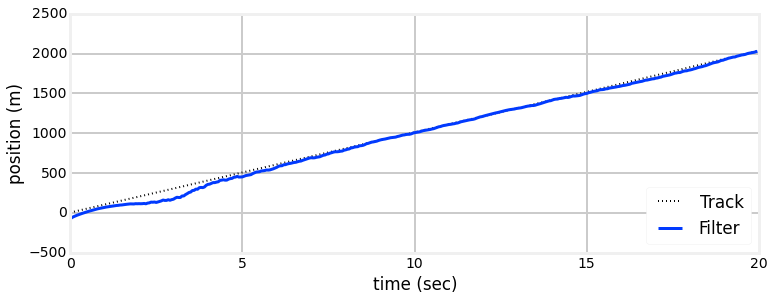

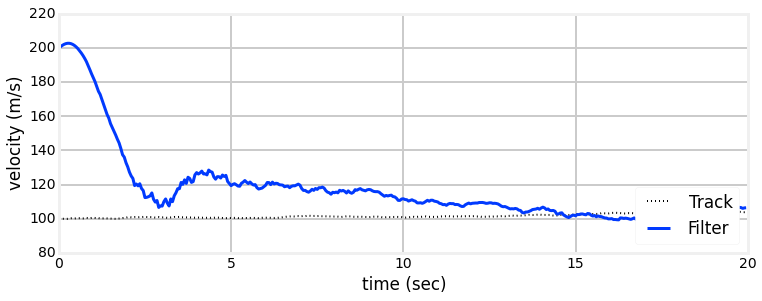

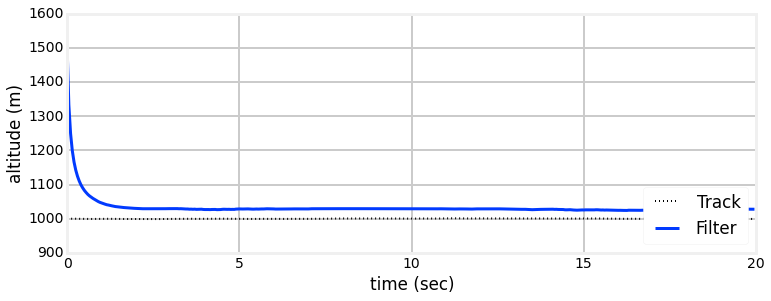

In [8]:
from filterpy.kalman import ExtendedKalmanFilter
from numpy import eye, array, asarray
import book_plots as bp

dt = 0.05
rk = ExtendedKalmanFilter(dim_x=3, dim_z=1)
radar = RadarSim(dt, pos=0., vel=100., alt=1000.)

# make an imperfect starting guess
rk.x = array([radar.pos-100, radar.vel+100, radar.alt+1000])


rk.F = eye(3) + array([[0, 1, 0],
                       [0, 0, 0],
                       [0, 0, 0]])*dt

rk.R = radar.alt * 0.05 # 5% of distance
rk.Q = array([[0, 0, 0],
              [0, 1, 0],
              [0, 0, 1]]) * 0.001
'''
wv = .1**2
wa = .1**2
rk.Q = array([[dt**3 * wv/3, dt**2*wv/2, 0],
              [dt**2*wv/2, dt*wv, 0],
              [0, 0, wa*dt]])'''
rk.P *= 50


xs = []
track = []
for i in range(int(20/dt)):
    z = radar.get_range()
    track.append((radar.pos, radar.vel, radar.alt))
    
    rk.update(array([z]), HJacobian_at, hx)
    xs.append(rk.x)
    rk.predict()


xs = asarray(xs)
track = asarray(track)
time = np.arange(0, len(xs)*dt, dt)

plt.figure()
bp.plot_track(time, track[:, 0])
bp.plot_filter(time, xs[:, 0])
plt.legend(loc=4)
plt.xlabel('time (sec)')
plt.ylabel('position (m)')


plt.figure()
bp.plot_track(time, track[:, 1])
bp.plot_filter(time, xs[:, 1])
plt.legend(loc=4)
plt.xlabel('time (sec)')
plt.ylabel('velocity (m/s)')

plt.figure()
bp.plot_track(time, track[:, 2])
bp.plot_filter(time, xs[:, 2])
plt.ylabel('altitude (m)')
plt.legend(loc=4)
plt.xlabel('time (sec)')
plt.ylim((900, 1600))
plt.show()

## Using SymPy to compute Jacobians

Depending on your experience with derivatives you may have found the computation of the Jacobian above either fairly straightforward, or quite difficult. Even if you found it easy, a slightly more difficult problem easily leads to very difficult computations.

As explained in Appendix A, we can use the SymPy package to compute the Jacobian for us. 

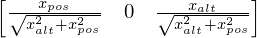

In [9]:
import sympy
sympy.init_printing()

x_pos, x_vel, x_alt = sympy.symbols('x_pos, x_vel x_alt')

H = sympy.Matrix([sympy.sqrt(x_pos**2 + x_alt**2)])

state = sympy.Matrix([x_pos, x_vel, x_alt])
H.jacobian(state)

This result is the same as the result we computed above, and at much less effort on our part!

## Designing Q

**author's note: ignore this, it  to be revised - noise in position and altitude is independent, not dependent**

Now we need to design the process noise matrix $\mathbf{Q}$. From the previous section we have the system equation

$$\dot{\mathbf{x}} = \begin{bmatrix} 0 & 1 & 0 \\ 0& 0& 0 \\ 0&0&0\end{bmatrix}
\begin{bmatrix}x_{pos} \\x_{vel}\\ x_{alt}\end{bmatrix} + \begin{bmatrix}0 \\w_{vel}\\ w_{alt}\end{bmatrix}
$$

where our process noise is

$$w = \begin{bmatrix}0 \\w_{vel}\\ w_{alt}\end{bmatrix}$$

We know from the Kalman filter math chapter that 

$$\mathbf{Q} = E(ww^T)$$

where $E(\bullet)$ is the expected value. We compute the expected value as

$$\mathbf{Q} = \int_0^{dt} \Phi(t)\mathbf{Q}\Phi^T(t) dt$$

Rather than do this by hand, let's use sympy.

In [10]:
import sympy
from sympy import Matrix
sympy.init_printing(use_latex='mathjax')
w_vel, w_alt, dt = sympy.symbols('w_vel w_alt \Delta{t}')
w = Matrix([[0, w_vel, w_alt]]).T
phi = Matrix([[1, dt, 0], [0, 1, 0], [0,0,1]])

q = w*w.T

sympy.integrate(phi*q*phi.T, (dt, 0, dt))

⎡           3      2                2      2             2            ⎤
⎢  \Delta{t} ⋅w_vel        \Delta{t} ⋅w_vel     \Delta{t} ⋅w_alt⋅w_vel⎥
⎢  ─────────────────       ─────────────────    ──────────────────────⎥
⎢          3                       2                      2           ⎥
⎢                                                                     ⎥
⎢           2      2                                                  ⎥
⎢  \Delta{t} ⋅w_vel                       2                           ⎥
⎢  ─────────────────       \Delta{t}⋅w_vel      \Delta{t}⋅w_alt⋅w_vel ⎥
⎢          2                                                          ⎥
⎢                                                                     ⎥
⎢         2                                                           ⎥
⎢\Delta{t} ⋅w_alt⋅w_vel                                           2   ⎥
⎢──────────────────────  \Delta{t}⋅w_alt⋅w_vel     \Delta{t}⋅w_alt    ⎥
⎣          2                                                    

## Robot Localization

So, time to try a real problem. I warn you that this is far from a simple problem. However, most books choose simple, textbook problems with simple answers, and you are left wondering how to implement a real world solution. 

We will consider the problem of robot localization. We already implemented this in the **Unscented Kalman Filter** chapter, and I recommend you read that first. In this scenario we have a robot that is moving through a landscape with sensors that give range and bearings to various landmarks. This could be a self driving car using computer vision to identify trees, buildings, and other landmarks. Or, it might be one of those small robots that  vacuum your house. It could be a search and rescue device meant to go into dangerous areas to search for survivors. It doesn't matter too much. 

Our robot is wheeled, which means that it manuevers by turning it's wheels. When it does so, the robot pivots around the rear axle while moving forward. This is nonlinear behavior which we will have to account for. The robot has a sensor that gives it approximate range and bearing to known targets in the landscape. This is nonlinear because computing a position from  a range and bearing requires square roots and trigonometry. 

### Robot Motion Model

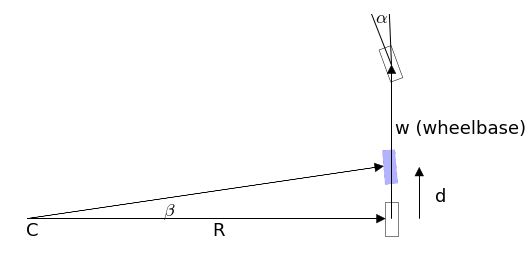

In [11]:
ekf_internal.plot_bicycle()

At a first approximation n automobile steers by turning the front tires while moving forward. The front of the car moves in the direction that the wheels are pointing while pivoting around the rear tires. This simple description is complicated by issues such as slippage due to friction, the differing behavior of the rubber tires at different speeds, and the need for the outside tire to travel a different radius than the inner tire. Accurately modelling steering requires an ugly set of differential equations. For Kalman filtering, especially for lower speed robotic applications a simpler *bicycle model* has been found to perform well. 

I have depicted this model above. Here we see the front tire is pointing in direction $\alpha$. Over a short time period the car moves forward and the rear wheel ends up further ahead and slightly turned inward, as depicted with the blue shaded tire. Over such a short time frame we can approximate this as a turn around a radius $R$. If you google bicycle model you will find that we can compute the turn angle $\beta$ with

$$\beta = \frac{d}{w} \tan{(\alpha)}$$

and the turning radius R is given by 

$$R = \frac{d}{\beta}$$

where the distance the rear wheel travels given a forward velocity $v$ is $d=v\Delta t$.

If we let $\theta$ be our current orientation then we can compute the position $C$ before the turn starts as

$$ C_x = x - R\sin(\theta) \\
C_y = y + R\cos(\theta)
$$

After the move forward for time $\Delta t$ the new position and orientation of the robot is

$$\begin{aligned} x &= C_x + R\sin(\theta + \beta) \\
y &= C_y - R\cos(\theta + \beta) \\
\theta &= \theta + \beta
\end{aligned}
$$

Once we substitute in for $C$ we get

$$\begin{aligned} x &= x - R\sin(\theta) + R\sin(\theta + \beta) \\
y &= y + R\cos(\theta) - R\cos(\theta + \beta) \\
\theta &= \theta + \beta
\end{aligned}
$$

You don't really need to understand this math in detail, as it is already a simplification of the real motion. The important thing to recognize is that our motion model is nonlinear, and we will need to deal with that with our Kalman filter.

### Design the State Variables

For our robot we will maintain the position and orientation of the robot:

$$\mathbf{x} = \begin{bmatrix}x \\ y \\ \theta\end{bmatrix}$$

I could include velocities into this model, but as you will see the math will already be quite challenging.

Our control input $\mathbf{u}$ is the velocity and steering angle

$$\mathbf{u} = \begin{bmatrix}v \\ \alpha\end{bmatrix}$$

### Design the System Model

In general we model our system as a nonlinear motion model plus noise.

$$x^- = x + f(x, u) + \mathcal{N}(0, Q)$$

Using the motion model for a robot that we created above, we can expand this to

$$\begin{bmatrix}x\\y\\\theta\end{bmatrix}^- = \begin{bmatrix}x\\y\\\theta\end{bmatrix} + 
\begin{bmatrix}- R\sin(\theta) + R\sin(\theta + \beta) \\
R\cos(\theta) - R\cos(\theta + \beta) \\
\beta\end{bmatrix}$$

We linearize this with a taylor expansion at $x$:

$$f(x, u) \approx \mathbf{x} + \frac{\partial f(x, u)}{\partial x}$$

We replace $f(x, u)$ with our state estimate $\mathbf{x}$, and the derivative is just the Jacobian of $f$.

The Jacobian $\mathbf{F}$ is

$$\mathbf{F} = \frac{\partial f(x, u)}{\partial x} =\begin{bmatrix}
\frac{\partial \dot{x}}{\partial x} & 
\frac{\partial \dot{x}}{\partial y} &
\frac{\partial \dot{x}}{\partial \theta}\\
\frac{\partial \dot{y}}{\partial x} & 
\frac{\partial \dot{y}}{\partial y} &
\frac{\partial \dot{y}}{\partial \theta} \\
\frac{\partial \dot{\theta}}{\partial x} & 
\frac{\partial \dot{\theta}}{\partial y} &
\frac{\partial \dot{\theta}}{\partial \theta}
\end{bmatrix}
$$

When we calculate these we get

$$\mathbf{F} = \begin{bmatrix}
1 & 0 & -R\cos(\theta) + R\cos(\theta+\beta) \\
0 & 1 & -R\sin(\theta) + R\sin(\theta+\beta) \\
0 & 0 & 1
\end{bmatrix}$$

We can double check our work with SymPy.

In [12]:
from sympy import symbols
a, x, y, v, w, theta, time = symbols('a, x, y, v, w, theta, t')
d = v*time
beta = (d/w)*sympy.tan(a)
R = w/sympy.tan(a)

fxu = Matrix([[x-R*sympy.sin(theta)+R*sympy.sin(theta+beta)],
              [y+R*sympy.cos(theta)-R*sympy.cos(theta+beta)],
              [theta+beta]])

fxu.jacobian(Matrix([x, y, theta]))

⎡                        ⎛t⋅v⋅tan(a)    ⎞⎤
⎢                   w⋅cos⎜────────── + θ⎟⎥
⎢        w⋅cos(θ)        ⎝    w         ⎠⎥
⎢1  0  - ──────── + ─────────────────────⎥
⎢         tan(a)            tan(a)       ⎥
⎢                                        ⎥
⎢                        ⎛t⋅v⋅tan(a)    ⎞⎥
⎢                   w⋅sin⎜────────── + θ⎟⎥
⎢        w⋅sin(θ)        ⎝    w         ⎠⎥
⎢0  1  - ──────── + ─────────────────────⎥
⎢         tan(a)            tan(a)       ⎥
⎢                                        ⎥
⎣0  0                  1                 ⎦

Now we can turn our attention to the noise. Here, the noise is in our control input, so it is in *control space*. In other words, we command a specific velocity and steering angle, but we need to convert that into errors in $x, y, \theta$. In a real system this might vary depending on velocity, so it will need to be recomputed for every prediction. I will chose this as the noise model; for a real robot you will need to choose a model that accurately depicts the error in your system. 

$$\mathbf{M} = \begin{bmatrix}0.01 vel^2 & 0 \\ 0 & \sigma_\alpha^2\end{bmatrix}$$

If this was a linear problem we would convert from control space to state space using the by now familiar $\mathbf{FMF}^\mathsf{T}$ form. Since our motion model is nonlinear we do not try to find a closed form solution to this, but instead linearize it with a Jacobian which we will name $\mathbf{V}$. 

$$\mathbf{V} = \frac{\partial f(x, u)}{\partial u} \begin{bmatrix}
\frac{\partial \dot{x}}{\partial v} & \frac{\partial \dot{x}}{\partial \alpha} \\
\frac{\partial \dot{y}}{\partial v} & \frac{\partial \dot{y}}{\partial \alpha} \\
\frac{\partial \dot{\theta}}{\partial v} & \frac{\partial \dot{\theta}}{\partial \alpha}
\end{bmatrix}$$

Let's just compute that with SymPy:

In [13]:
fxu.jacobian(Matrix([v, a]))

⎡                           ⎛   2       ⎞    ⎛t⋅v⋅tan(a)    ⎞                 
⎢                       t⋅v⋅⎝tan (a) + 1⎠⋅cos⎜────────── + θ⎟     ⎛     2     
⎢     ⎛t⋅v⋅tan(a)    ⎞                       ⎝    w         ⎠   w⋅⎝- tan (a) -
⎢t⋅cos⎜────────── + θ⎟  ───────────────────────────────────── - ──────────────
⎢     ⎝    w         ⎠                  tan(a)                             2  
⎢                                                                       tan (a
⎢                                                                             
⎢                           ⎛   2       ⎞    ⎛t⋅v⋅tan(a)    ⎞                 
⎢                       t⋅v⋅⎝tan (a) + 1⎠⋅sin⎜────────── + θ⎟     ⎛     2     
⎢     ⎛t⋅v⋅tan(a)    ⎞                       ⎝    w         ⎠   w⋅⎝- tan (a) -
⎢t⋅sin⎜────────── + θ⎟  ───────────────────────────────────── + ──────────────
⎢     ⎝    w         ⎠                  tan(a)                             2  
⎢                                                   


**authors note: explain FPF better**

This gives us the final form of our prediction equations:

$$\begin{aligned}
\mathbf{x}^- &= \mathbf{x} + 
\begin{bmatrix}- R\sin(\theta) + R\sin(\theta + \beta) \\
R\cos(\theta) - R\cos(\theta + \beta) \\
\beta\end{bmatrix}\\
\mathbf{P}^- &=\mathbf{FPF}^{\mathsf{T}} + \mathbf{VMV}^{\mathsf{T}}
\end{aligned}$$

One final point. This form of linearization is not the only way to predict $\mathbf{x}$. For example, we could use a numerical integration technique like *Runge Kutta* to compute the position of the robot in the future. In fact, if the time step is relatively large you will have to do that. As I am sure you are realizing, things are not as cut and dried with the EKF as it was for the KF. For a real problem you have to very carefully model your system with differential equations and then determine the most appropriate way to solve that system. The correct approach depends on the accuracy you require, how nonlinear the equations are, your processor budget, and numerical stability concerns. These are all topics beyond the scope of this book.

### Design the Measurement Model

Now we need to design our measurement model. For this problem we are assuming that we have a sensor that receives a noisy bearing and range to multiple known locations in the landscape. The measurement model must convert the state $\begin{bmatrix}x & y&\theta\end{bmatrix}^\mathsf{T}$ into a range and bearing to the landmark. Using $p$ be the position of a landmark, the range $r$ is

$$r = \sqrt{(p_x - x)^2 + (p_y - y)^2}$$

We assume that the sensor provides bearing relative to the orientation of the robot, so we must subtract the robot's orientation from the bearing to get the sensor reading, like so:

$$\phi = \arctan(\frac{p_y - y}{p_x - x}) - \theta$$


Thus our function is


$$\begin{aligned}
\mathbf{x}& = h(x,p) &+ \mathcal{N}(0, R)\\
&= \begin{bmatrix}
\sqrt{(p_x - x)^2 + (p_y - y)^2} \\
\arctan(\frac{p_y - y}{p_x - x}) - \theta 
\end{bmatrix} &+ \mathcal{N}(0, R)
\end{aligned}$$

This is clearly nonlinear, so we need linearize $h(x, p)$  at $\mathbf{x}$ by taking its Jacobian. We compute that with SymPy below.

In [14]:
px, py = symbols('px, py')
z = Matrix([[sympy.sqrt((px-x)**2 + (py-y)**2)],
            [sympy.atan2(py-y, px-x) - theta]])
z.jacobian(Matrix([x, y, theta]))

⎡         -px + x                     -py + y              ⎤
⎢──────────────────────────  ──────────────────────────  0 ⎥
⎢   _______________________     _______________________    ⎥
⎢  ╱         2           2     ╱         2           2     ⎥
⎢╲╱  (px - x)  + (py - y)    ╲╱  (px - x)  + (py - y)      ⎥
⎢                                                          ⎥
⎢       -(-py + y)                   -(px - x)             ⎥
⎢  ─────────────────────       ─────────────────────     -1⎥
⎢          2           2               2           2       ⎥
⎣  (px - x)  + (py - y)        (px - x)  + (py - y)        ⎦

Now we need to write that as a Python function. For example we might write:

In [15]:
from math import sqrt

def H_of(x, landmark_pos):
    """ compute Jacobian of H matrix where h(x) computes the range and
    bearing to a landmark for state x """

    px = landmark_pos[0]
    py = landmark_pos[1]
    hyp = (px - x[0, 0])**2 + (py - x[1, 0])**2
    dist = sqrt(hyp)

    H = array(
        [[-(px - x[0, 0]) / dist, -(py - x[1, 0]) / dist, 0],
         [ (py - x[1, 0]) / hyp,  -(px - x[0, 0]) / hyp, -1]])
    return H

We also need to define a function that converts the system state into a measurement.

In [16]:
from math import atan2
def Hx(x, landmark_pos):
    """ takes a state variable and returns the measurement that would
    correspond to that state.
    """
    px = landmark_pos[0]
    py = landmark_pos[1]
    dist = sqrt((px - x[0, 0])**2 + (py - x[1, 0])**2)

    Hx = array([[dist],
                [atan2(py - x[1, 0], px - x[0, 0]) - x[2, 0]]])
    return Hx

### Design Measurement Noise

This is quite straightforward as we need to specify measurement noise in measurement space, hence it is linear. It is reasonable to assume that the range and bearing measurement noise is independent, hence

$$R=\begin{bmatrix}\sigma_{range}^2 & 0 \\ 0 & \sigma_{bearing}^2\end{bmatrix}$$

### Implementation

We will use `FilterPy`'s `ExtendedKalmanFilter` class to implment the filter. The prediction of $\mathbf{x}$ is nonlinear, so we will have to override the method `predict()` to implement this. I'll want to also use this code to simulate the robot, so I'll add a method `move()` that computes the position of the robot which both `predict()` and my simulation can call. You would not need to do this for a real robot, of course.

The matrices for the prediction step are quite large; while trying to implement this I made several errors before I finally got it working. I only found my errors by using SymPy's `evalf` function, which allows you to evaluate a SymPy `Matrix` for specific values of the variables. I decided to demonstrate this technique, and to eliminate a possible source of bugs, by using SymPy in the Kalman filter. You'll need to understand a couple of points.

First, `evalf` uses a dictionary to pass in the values you want to use. For example, if your matrix contains an x and y, you can write

    M.evalf(subs={x:3, y:17})
    
to evaluate the matrix for `x=3` and `y=17`. 

Second, `evalf` returns a `sympy.Matrix` object. You can convert it to a numpy array with `numpy.array(m)`, but the result uses type `object` for the elements in the array. You can convert the array to an array of floats with ``numpy.array(m).astype(float)`.

So, here is the code:

In [17]:
from filterpy.kalman import ExtendedKalmanFilter as EKF
from numpy import dot, array, sqrt
class RobotEKF(EKF):
    def __init__(self, dt, wheelbase, sigma_vel, sigma_steer):
        EKF.__init__(self, 3, 2, 2)
        self.dt = dt
        self.wheelbase = wheelbase
        self.sigma_vel = sigma_vel
        self.sigma_steer = sigma_steer

        a, x, y, v, w, theta, time = symbols('a, x, y, v, w, theta, t')
        d = v*time
        beta = (d/w)*sympy.tan(a)
        r = w/sympy.tan(a)
    
        self.fxu = Matrix([[x-r*sympy.sin(theta)+r*sympy.sin(theta+beta)],
                           [y+r*sympy.cos(theta)-r*sympy.cos(theta+beta)],
                           [theta+beta]])

        self.F_j = self.fxu.jacobian(Matrix([x, y, theta]))
        self.V_j = self.fxu.jacobian(Matrix([v, a]))

        # save dictionary and it's variables for later use
        self.subs = {x: 0, y: 0, v:0, a:0, time:dt, w:wheelbase, theta:0}
        self.x_x, self.x_y, self.v, self.a, self.theta = x, y, v, a, theta

    def predict(self, u=0):
        self.x = self.move(self.x, u, self.dt)

        self.subs[self.theta] = self.x[2, 0]
        self.subs[self.v] = u[0]
        self.subs[self.a] = u[1]

        F = array(self.F_j.evalf(subs=self.subs)).astype(float)
        V = array(self.V_j.evalf(subs=self.subs)).astype(float)

        # covariance of motion noise in control space
        M = array([[self.sigma_vel*u[0]**2, 0], [0, self.sigma_steer**2]])

        self.P = dot(F, self.P).dot(F.T) + dot(V, M).dot(V.T)

    def move(self, x, u, dt):
        h = x[2, 0]
        v = u[0]
        steering_angle = u[1]

        dist = v*dt

        if abs(steering_angle) < 0.0001:
            # approximate straight line with huge radius
            r = 1.e-30
        b = dist / self.wheelbase * tan(steering_angle)
        r = self.wheelbase / tan(steering_angle) # radius
        sinh = sin(h)
        sinhb = sin(h + b)
        cosh = cos(h)
        coshb = cos(h + b)
        return x + array([[-r*sinh + r*sinhb],
                          [r*cosh - r*coshb],
                          [b]])

Now we have another issue to handle. The residual is notionally computed as $y = z - h(x)$ but this will not work because our measurement contains an angle in it. Suppose z has a bearing of $1^\circ$ and $h(x)$ has a bearing of $359^\circ$. Naively subtracting them would yield a bearing difference of $-358^\circ$, which will throw off the computation of the Kalman gain. The correct angle difference in this case is $-2^\circ$. So we will have to write code to correctly compute the bearing residual.

In [18]:
def residual(a,b):
    """ compute residual between two measurement containing [range, bearing]. Bearing
    is normalized to [0, 360)"""
    y = a - b
    if y[1] > np.pi:
        y[1] -= 2*np.pi
    if y[1] < -np.pi:
        y[1] += 2*np.pi
    return y

The rest of the code runs the simulation and plots the results, and shouldn't need too much comment by now. I create a variable `landmarks` that contains the coordinates of the landmarks. I update the simulated robot position 10 times a second, but run the EKF only once. This is for two reasons. First, we are not using Runge Kutta to integrate the differental equations of motion, so a narrow time step allows our simulation to be more accurate. Second, it is fairly normal in embedded systems to have limited processing speed. This forces you to run your Kalman filter only as frequently as absolutely needed.

In [19]:
from filterpy.stats import plot_covariance_ellipse
from math import sqrt, tan, cos, sin, atan2
dt = 1.0

def run_localization(landmarks, sigma_vel, sigma_steer, sigma_range, sigma_bearing):
    ekf = RobotEKF(dt, wheelbase=0.5, sigma_vel=sigma_vel, sigma_steer=sigma_steer)
    ekf.x = array([[2, 6, .3]]).T
    ekf.P = np.diag([.1, .1, .1])
    ekf.R = np.diag([sigma_range**2, sigma_bearing**2])

    sim_pos = ekf.x.copy() # simulated position
    u = array([1.1, .01]) # steering command (vel, steering angle radians)

    plt.scatter(landmarks[:, 0], landmarks[:, 1], marker='s', s=60)
    for i in range(200):
        sim_pos = ekf.move(sim_pos, u, dt/10.) # simulate robot
        plt.plot(sim_pos[0], sim_pos[1], ',', color='g')

        if i % 10 == 0:
            ekf.predict(u=u)

            plot_covariance_ellipse((ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2], std=6,
                                    facecolor='b', alpha=0.08)

            x, y = sim_pos[0, 0], sim_pos[1, 0]
            for lmark in landmarks:
                d = np.sqrt((lmark[0] - x)**2 + (lmark[1] - y)**2)  
                a = atan2(lmark[1] - y, lmark[0] - x) - sim_pos[2, 0]
                z = np.array([[d + randn()*sigma_range], [a + randn()*sigma_bearing]])

                ekf.update(z, HJacobian=H_of, Hx=Hx, residual=residual,
                           args=(lmark), hx_args=(lmark))

            plot_covariance_ellipse((ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2], std=6,
                                    facecolor='g', alpha=0.4)
    plt.axis('equal')
    #plt.xlim((0,20))
    plt.show()
    return ekf

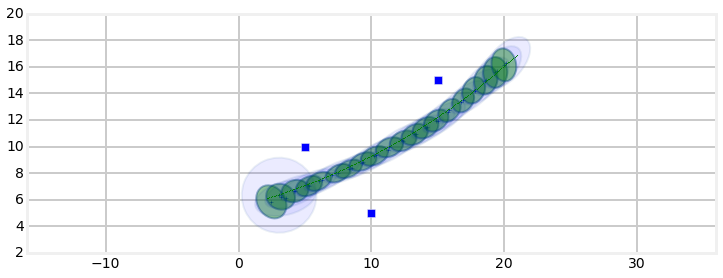

[ 0.02426139  0.0425823   0.00221613]


In [20]:
landmarks = array([[5, 10], [10, 5], [15, 15], [20, 5]])
landmarks = array([[5, 10], [10, 5], [15, 15]])

ekf = run_localization(landmarks, sigma_vel=0.1, sigma_steer=np.radians(1),
                      sigma_range=0.3, sigma_bearing=0.1)
print(ekf.P.diagonal())

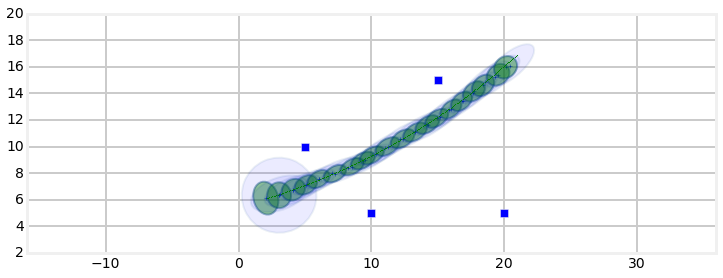

[ 0.02089027  0.01976026  0.00153243]


In [21]:
landmarks = array([[5, 10], [10, 5], [15, 15], [20, 5]])

ekf = run_localization(landmarks, sigma_vel=0.1, sigma_steer=np.radians(1),
                      sigma_range=0.3, sigma_bearing=0.1)
print(ekf.P.diagonal())

I have plotted the landmarks as solid squares. The path of the robot is drawn with a dashed line, which is admittedly hard to see. The covariance after the predict step is drawn in a very light shade of blue, and the covariance after all of the landmark measurements are incorporated are shown in green. To make them visible at this scale I have set the ellipse boundary at 6$\sigma$.

From this we can see that there is a lot of uncertainty added by our motion model, and that most of the error in in the direction of motion. We can see that from the shape of the blue ellipses. After a few steps we can see that the filter incorporates the landmark measurements. 

We can see the fantastic effect that multiple landmarks has on our uncertainty by only using the first two landmarks.

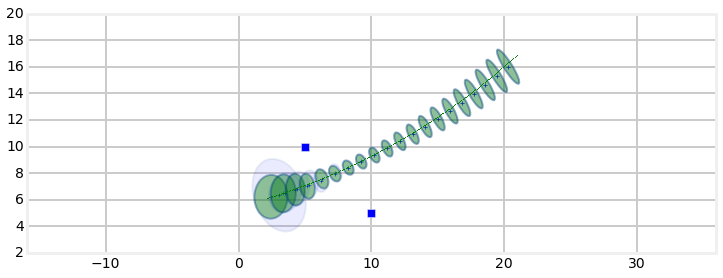

[ 0.01961672  0.04581986  0.0002252 ]


In [22]:
ekf = run_localization(landmarks[0:2], sigma_vel=1.e-10, sigma_steer=1.e-10,
                       sigma_range=1.4, sigma_bearing=.05)
print(ekf.P.diagonal())

We can see that the covariance gets smaller as it passes through the landmarks but quickly expands once past them. Let's see what happens with only one landmark

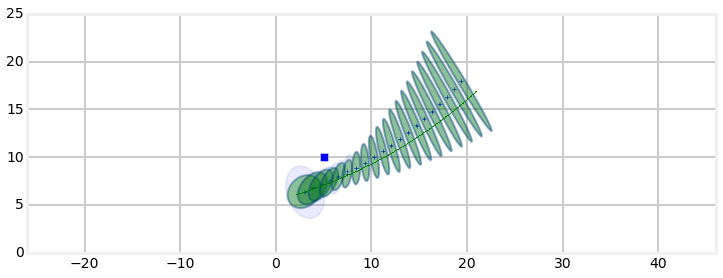

[ 0.27794637  0.75174993  0.00348487]


In [23]:
ekf = run_localization(landmarks[0:1], sigma_vel=1.e-10, sigma_steer=1.e-10,
                       sigma_range=1.4, sigma_bearing=.05)
print(ekf.P.diagonal())

As you probably suspected, only one landmark produces a very bad covariance. What is worse, the filter starts to diverge from the robot's path. On the other hand, a large number of landmarks allows us to make very accurate estimates.

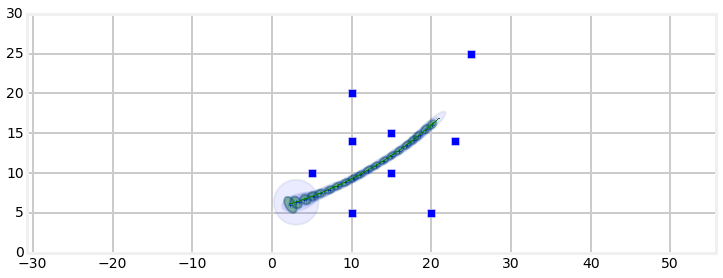

[ 0.00894682  0.00859964  0.00077197]


In [24]:
landmarks = array([[5, 10], [10,  5], [15, 15], [20,  5], [15, 10], 
                   [10,14], [23, 14], [25, 25], [10, 20]])

ekf = run_localization(landmarks, sigma_vel=0.1, sigma_steer=np.radians(1),
                      sigma_range=0.3, sigma_bearing=0.1)
print(ekf.P.diagonal())

### Discussion

I said that this was a 'real' problem, and in some ways it is. I've seen alternative presentations that used robot motion models that led to much easier Jacobians. On the other hand, my model of a automobile's movement is itself simplistic in several ways. First, it uses the *bicycle model* to compute how it moves. A real car has two sets of tires, and each travels on a different radius. The wheels do not grip the surface perfectly. I also assumed that the robot was able to instaneously respond to my control input changes. In fact, I didn't even bother changing the control input during the run. Sebastian Thrun writes in *Probabalistic Robots* that simplied models are justified because the filters perform well when used to track real vehicles. The lesson here is that while you have to have a reasonably accurate nonlinear model, it does not need to be perfect to operate well. As a designer you will need to balance the fidelity of your model with the difficulty of the math and the computation required to implement the equations. 

Another way in which this problem was simplistic is that we assumed that we knew the correspondance between the landmarks and measurements. But suppose we are using radar - how would we know that a specific signal return corresponded to a specific building in the local scene? This question hints at SLAM algorithms - simultaneous localization and mapping. SLAM is not the point of this book, so I will not elaborate on this topic. 

However, this example should underscore how difficult EKFs can be. EKF have a well deserved reputation for difficulty. Especially when the problem is highly nonlinear you must design 

## UKF vs EKF

I implemented this tracking problem using and unscented Kalman filter in the previous chapter. The difference in implementation should be very clear. Computing the Jacobians for the state and measurement models was not trivial and we used a very rudimentary model for the motion of the car. I am justified in using this model because the research resulting from the DARPA car challenges has shown that it works well in practice. Nonetheless, a different problem, such as an aircraft or rocket will yield a very difficult to impossible to compute Jacobian. In contrast, the UKF only requires you to provide a function that computes the system motion model and another for the measurement model. This is will always be easier than deriving a Jacobian analytically. In fact, there are many physical processes for which we cannot find an analytical solution. It is beyond the scope of this book, but in that case you have to design a numerical method to compute the Jacobian. That is a very nontrivial undertaking, and you will spend a significant portion of a master's degree at a STEM school learning various techniques to handle such situations. Even then you'll likely only be able to solve problems related to your field - an aeronautical engineer learns a lot about Navier Stokes equations, but not much about modelling chemical reaction rates. 

So, UKFs are easy. Are they accurate? Everything I have read states that there is no way to prove that a UKF will always perform as well or better than an EKF. However, in practice, they do perform better. You can search and find any number of research papers that prove that the UKF outperforms the EKF in various problem domains. It's not hard to understand why this would be true. The EKF works by linearizing the system model and measurement model at a single point. 

Let's look at a specific example. I will take the function $f(x) = x^3$ as our nonlinear function and pass a Gaussian distribution through it. I will compute an accurate answer using a monte carlo simulation. I do this by generating 50,000 points distributed according to the Gaussian, passing each point through the function, and then computing the mean and variance of the result. 

First, let's see how the EKF fairs. The EkF linearizes the function by taking the derivative and evaluating it the mean $x$ to get the slope tangent to the function at that point. This slope becomes the linear function that we use to transform the Gaussian. Here is a plot of that.

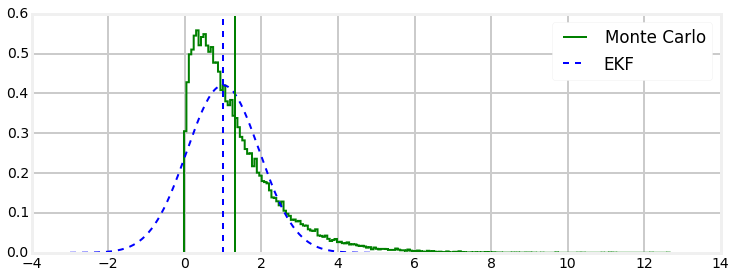

actual mean=1.30, std=1.13
EKF    mean=1.00, std=0.95


In [25]:
import nonlinear_plots
nonlinear_plots.plot_ekf_vs_mc()

We can see from both the graph and the print out at the bottom that the EKF has introduced quite a bit of error.

In contrast, here is the performance of the UKF evaluated with the same Gaussian and function.b

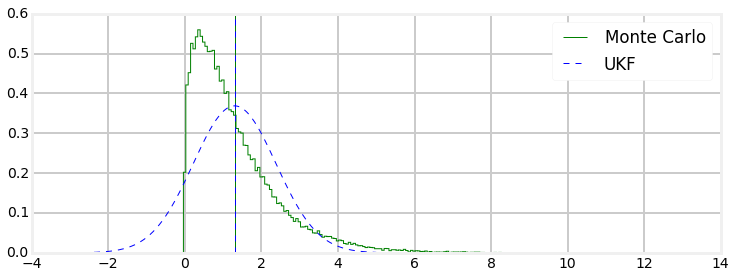

actual mean=1.31, std=1.13
UKF    mean=1.30, std=1.08


In [26]:
nonlinear_plots.plot_ukf_vs_mc(alpha=0.001, beta=3., kappa=1.)

Here we can see that the computation of the UKF's mean is accurate to 2 decimal places. The standard deviation is slightly off, but you can also fine tune how the UKF computes the distribution by using the $\alpha$, $\beta$, and $\gamma$ parameters for generating the sigma points. Here I used $\alpha=0.001$, $\beta=3$, and $\gamma=1$. Feel free to modify them in the function call to see the result - you should be able to get better results than I did. However, ovoid overtuning the UKF for a specific test - it may perform better for your test case, but worse in general.

This is one contrived example, but as I said the literature is filled with detailed studies of real world problems that exhibit similar performance differences between the two filters.